# Heston/Hull-White Model

## Imports

In [14]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from optimizer import *
import plotly.graph_objects as go
from nets import *
from scipy.stats import norm

%matplotlib widget

DEV = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
DTYPE = torch.float32

## Parameters

In [2]:
s_min, s_max = 0.0, 1.0
v_min, v_max = 0.0, 1.0
r_min, r_max = -1.0, 1.0
STRIKE = s_max/2
T = 5

DIM_RANGES = dict(tau=(0.0, 1.0), s=(s_min, s_max), r=(r_min, r_max), v=(v_min, v_max) )

KAPPA_R = 0.01
THETA_R = 0.05
SIGMA_R = 0.05

KAPPA_V = 0.01
THETA_V = 0.05
SIGMA_V = 0.05

RHO_SV = -0.5
RHO_SR = -0.5
RHO_VR = 0.0

In [3]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_layers):
        super().__init__()
        layers = []
        prev_dim = in_dim

        for h in hidden_layers:
            layers += [nn.Linear(prev_dim, h, dtype=DTYPE), nn.Tanh()]
            prev_dim = h

        layers.append(nn.Linear(prev_dim, out_dim, dtype=DTYPE))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        base = self.model(x).squeeze()
        return base

In [4]:
def P_VK(tau, r, kappa_r, theta_r, sigma_r):
    dt = tau * T
    B = (1.0 - torch.exp(-kappa_r * dt)) / kappa_r
    A = torch.exp((theta_r - sigma_r**2 / (2*kappa_r**2)) * (B - dt)- sigma_r**2 / (4*kappa_r) * B**2)
    return A * torch.exp(-B * r)

def pde_residual(model, coords):
    tau, s, r, v = coords.T    
    v_sqrt   = torch.sqrt(v)  
    coords.requires_grad_(True)
    u = model(coords).squeeze()
    grads = torch.autograd.grad(u, coords,
                                grad_outputs=torch.ones_like(u),
                                create_graph=True, retain_graph=True)[0]
    u_tau, u_s, u_r, u_v = grads.T
    g_s = torch.autograd.grad(u_s.sum(), coords,
                              create_graph=True, retain_graph=True)[0]
    u_ss, u_sr, u_sv = g_s[:, 1], g_s[:, 2], g_s[:, 3]
    g_r = torch.autograd.grad(u_r.sum(), coords,
                              create_graph=True, retain_graph=True)[0]
    u_rr, u_rv = g_r[:, 2], g_r[:, 3]
    g_v = torch.autograd.grad(u_v.sum(), coords,
                              create_graph=True, retain_graph=True)[0]
    u_vv = g_v[:, 3]
    drift = r * s * u_s + KAPPA_R * (THETA_R - r) * u_r + KAPPA_V * (THETA_V - v) * u_v
    diff = 0.5 * (v * s**2 * u_ss + SIGMA_R**2 * u_rr + SIGMA_V**2 * v * u_vv
                  + 2 * RHO_SV * SIGMA_V * v * s * u_sv
                  + 2 * RHO_SR * SIGMA_R * s * v_sqrt * u_sr
                  + 2 * RHO_VR * SIGMA_V * SIGMA_R * v_sqrt * u_rv)
    return -u_tau / T + diff + drift - r * u



def u_and_grads(model, coords, second_order=False):
    coords.requires_grad_(True)
    u = model(coords)                               # (N , 1)
    g = torch.autograd.grad(u.sum(), coords,create_graph=True, retain_graph=True)[0]
    _, u_s, u_r, u_v = g.T
    if second_order:
        g1 = torch.autograd.grad(u_s.sum(), coords,create_graph=True, retain_graph=True)[0]
        u_ss = g1[:, 1]
    else:
        u_ss = None
    return u, u_s, u_r, u_v, u_ss

def loss_interior(model, coords):
    res = pde_residual(model, coords)
    return res.pow(2).mean()

def loss_s_bottom(model, coords):
    u = model(coords)
    return u.pow(2).mean()

def loss_s_upper(model, coords):
    u = model(coords)
    tau, s, r, _ = coords.T
    df = P_VK(tau, r, KAPPA_R, THETA_R, SIGMA_R)
    v = s - df*STRIKE
    return (u - v).pow(2).mean()
    
def loss_v_lower(model, coords):
    u = model(coords)
    tau, s, r, _ = coords.T
    df = P_VK(tau, r, KAPPA_R, THETA_R, SIGMA_R)
    v = torch.clamp(s - df*STRIKE, min=0.0)
    return (u - v).pow(2).mean()


def loss_v_upper(model, coords):
    u = model(coords)
    tau, s, r, v = coords.T
    return (u-s).pow(2).mean()


def loss_r_lower(model, coords):
    u = model(coords)    
    return u.pow(2).mean()


def loss_r_upper(model, coords):
    u = model(coords)
    tau, s, r, v = coords.T
    return (u-s).pow(2).mean()


def loss_payoff(model, coords):
    tau, s, r, v = coords.T
    target = torch.clamp(s - STRIKE, min=0.0)  # Call option payoff
    pred = model(coords)
    return (pred - target).pow(2).mean()

In [5]:
def generate_samples(n_int: int = 256, n_bdry: int = 64, n_pay: int = 64):
    
    # Generate interior points in actual dimensional ranges
    tau = torch.rand(n_int, device=DEV, dtype=DTYPE) * (DIM_RANGES["tau"][1] - DIM_RANGES["tau"][0]) + DIM_RANGES["tau"][0]
    s = torch.rand(n_int, device=DEV, dtype=DTYPE) * (DIM_RANGES["s"][1] - DIM_RANGES["s"][0]) + DIM_RANGES["s"][0]
    r = torch.rand(n_int, device=DEV, dtype=DTYPE) * (DIM_RANGES["r"][1] - DIM_RANGES["r"][0]) + DIM_RANGES["r"][0]
    v = torch.rand(n_int, device=DEV, dtype=DTYPE) * (DIM_RANGES["v"][1] - DIM_RANGES["v"][0]) + DIM_RANGES["v"][0]
    
    interior = torch.stack([tau, s, r, v], dim=1)
    
    # Generate boundary faces
    faces = []
    
    # tau boundaries (but tau goes from 0 to 1, so we keep tau=0 and tau=1)
    # for tau_val in [DIM_RANGES["tau"][0], DIM_RANGES["tau"][1]]:
    #     tau_face = torch.full((n_bdry,), tau_val, device=DEV, dtype=DTYPE)
    #     s_face = torch.rand(n_bdry, device=DEV, dtype=DTYPE) * (DIM_RANGES["s"][1] - DIM_RANGES["s"][0]) + DIM_RANGES["s"][0]
    #     r_face = torch.rand(n_bdry, device=DEV, dtype=DTYPE) * (DIM_RANGES["r"][1] - DIM_RANGES["r"][0]) + DIM_RANGES["r"][0]
    #     v_face = torch.rand(n_bdry, device=DEV, dtype=DTYPE) * (DIM_RANGES["v"][1] - DIM_RANGES["v"][0]) + DIM_RANGES["v"][0]
    #     faces.append(torch.stack([tau_face, s_face, r_face, v_face], dim=1))
    
    # s boundaries
    for s_val in [DIM_RANGES["s"][0], DIM_RANGES["s"][1]]:
        tau_face = torch.rand(n_bdry, device=DEV, dtype=DTYPE) * (DIM_RANGES["tau"][1] - DIM_RANGES["tau"][0]) + DIM_RANGES["tau"][0]
        s_face = torch.full((n_bdry,), s_val, device=DEV, dtype=DTYPE)
        r_face = torch.rand(n_bdry, device=DEV, dtype=DTYPE) * (DIM_RANGES["r"][1] - DIM_RANGES["r"][0]) + DIM_RANGES["r"][0]
        v_face = torch.rand(n_bdry, device=DEV, dtype=DTYPE) * (DIM_RANGES["v"][1] - DIM_RANGES["v"][0]) + DIM_RANGES["v"][0]
        faces.append(torch.stack([tau_face, s_face, r_face, v_face], dim=1))
    
    # r boundaries
    for r_val in [DIM_RANGES["r"][0], DIM_RANGES["r"][1]]:
        tau_face = torch.rand(n_bdry, device=DEV, dtype=DTYPE) * (DIM_RANGES["tau"][1] - DIM_RANGES["tau"][0]) + DIM_RANGES["tau"][0]
        s_face = torch.rand(n_bdry, device=DEV, dtype=DTYPE) * (DIM_RANGES["s"][1] - DIM_RANGES["s"][0]) + DIM_RANGES["s"][0]
        r_face = torch.full((n_bdry,), r_val, device=DEV, dtype=DTYPE)
        v_face = torch.rand(n_bdry, device=DEV, dtype=DTYPE) * (DIM_RANGES["v"][1] - DIM_RANGES["v"][0]) + DIM_RANGES["v"][0]
        faces.append(torch.stack([tau_face, s_face, r_face, v_face], dim=1))
    
    # v boundaries
    for v_val in [DIM_RANGES["v"][0], DIM_RANGES["v"][1]]:
        tau_face = torch.rand(n_bdry, device=DEV, dtype=DTYPE) * (DIM_RANGES["tau"][1] - DIM_RANGES["tau"][0]) + DIM_RANGES["tau"][0]
        s_face = torch.rand(n_bdry, device=DEV, dtype=DTYPE) * (DIM_RANGES["s"][1] - DIM_RANGES["s"][0]) + DIM_RANGES["s"][0]
        r_face = torch.rand(n_bdry, device=DEV, dtype=DTYPE) * (DIM_RANGES["r"][1] - DIM_RANGES["r"][0]) + DIM_RANGES["r"][0]
        v_face = torch.full((n_bdry,), v_val, device=DEV, dtype=DTYPE)
        faces.append(torch.stack([tau_face, s_face, r_face, v_face], dim=1))
    
    # Payoff points (tau = 0)
    tau_pay = torch.zeros(n_pay, device=DEV, dtype=DTYPE)
    s_pay = torch.rand(n_pay, device=DEV, dtype=DTYPE) * (DIM_RANGES["s"][1] - DIM_RANGES["s"][0]) + DIM_RANGES["s"][0]
    r_pay = torch.rand(n_pay, device=DEV, dtype=DTYPE) * (DIM_RANGES["r"][1] - DIM_RANGES["r"][0]) + DIM_RANGES["r"][0]
    v_pay = torch.rand(n_pay, device=DEV, dtype=DTYPE) * (DIM_RANGES["v"][1] - DIM_RANGES["v"][0]) + DIM_RANGES["v"][0]
    pay = torch.stack([tau_pay, s_pay, r_pay, v_pay], dim=1)
    
    X = torch.cat([interior, *faces, pay], dim=0)
    
    # Masks using actual range values
    x0, x1, x2, x3 = X[:, 0], X[:, 1], X[:, 2], X[:, 3]
    eps = 1e-6  # small tolerance for floating point comparisons
    
    masks = {
        "interior": (x0 > DIM_RANGES["tau"][0] + eps) & 
                   (x1 > DIM_RANGES["s"][0] + eps) & (x1 < DIM_RANGES["s"][1] - eps) & 
                   (x2 > DIM_RANGES["r"][0] + eps) & (x2 < DIM_RANGES["r"][1] - eps) & 
                   (x3 > DIM_RANGES["v"][0] + eps) & (x3 < DIM_RANGES["v"][1] - eps),
        "S0": torch.abs(x1 - DIM_RANGES["s"][0]) < eps,
        "S1": torch.abs(x1 - DIM_RANGES["s"][1]) < eps,
        "r0": torch.abs(x2 - DIM_RANGES["r"][0]) < eps,
        "r1": torch.abs(x2 - DIM_RANGES["r"][1]) < eps,
        "v0": torch.abs(x3 - DIM_RANGES["v"][0]) < eps,
        "v1": torch.abs(x3 - DIM_RANGES["v"][1]) < eps,
        "pay": torch.abs(x0 - DIM_RANGES["tau"][0]) < eps
    }
    return X, masks

In [6]:
def train_lbfgs(model, coords, masks, max_iter=500):
    model.to(DEV)
    X = coords.to(DEV)
    masks = {k: v.to(DEV) for k, v in masks.items()}

    def slc(key):
        m = masks[key]
        return X[m]

    optimizer = SSBroyden(model.parameters(), max_iter=max_iter, tolerance_change=1e-10, tolerance_grad=1e-10)

    def closure(*args, **kwargs):
        optimizer.zero_grad()

        # Print individual loss components
        loss_int = loss_interior(model, slc("interior"))
        loss_s0 = loss_s_bottom(model, slc("S0"))
        loss_s1 = loss_s_upper(model, slc("S1"))
        loss_v0 = loss_v_lower(model, slc("v0"))
        loss_v1 = loss_v_upper(model, slc("v1"))
        loss_r0 = loss_r_lower(model, slc("r0"))
        loss_r1 = loss_r_upper(model, slc("r1"))
        loss_pay = 10*loss_payoff(model, slc("pay"))
        loss = (loss_int + loss_s0 + loss_s1 + loss_v0 + loss_v1 + loss_r0 + loss_r1 + loss_pay)
        print(f"Total: {loss.item():.8e}, Interior: {loss_int.item():.8e}, "
              f"S0: {loss_s0.item():.8e}, S1: {loss_s1.item():.8e}, "
              f"V0: {loss_v0.item():.8e}, V1: {loss_v1.item():.8e}, "
              f"R0: {loss_r0.item():.8e}, R1: {loss_r1.item():.8e}, "
                f"Payoff: {loss_pay.item():.8e}")
        loss.backward()
        return loss

    final = optimizer.step(closure)
    print(f"LBFGS finished - final loss = {final:.8e}")

In [7]:
model = MLP(in_dim=4, out_dim=1, hidden_layers=[60, 60, 60])
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [348]:
torch.manual_seed(0)
n_bdy = 10_000
n_int = n_bdy//6
n_pay = n_int
X, M = generate_samples(n_int=n_int, n_bdry=n_bdy, n_pay=n_pay)

In [349]:
print(f"Generated {X.shape[0]} coordinates.")
train_lbfgs(model, X, M, max_iter=20_000)

Generated 63332 coordinates.
Total: 1.37429428e+01, Interior: 1.89736351e-01, S0: 5.08047879e-01, S1: 1.47078705e+00, V0: 8.70307982e-01, V1: 1.41528845e+00, R0: 5.54490328e-01, R1: 1.48142660e+00, Payoff: 7.25285816e+00
Total: 1.10608692e+01, Interior: 1.45979553e-01, S0: 3.88981521e-01, S1: 1.22920525e+00, V0: 7.04527557e-01, V1: 1.19154155e+00, R0: 4.20132726e-01, R1: 1.26208246e+00, Payoff: 5.71841812e+00
Total: 1.10608692e+01, Interior: 1.45979553e-01, S0: 3.88981521e-01, S1: 1.22920525e+00, V0: 7.04527557e-01, V1: 1.19154155e+00, R0: 4.20132726e-01, R1: 1.26208246e+00, Payoff: 5.71841812e+00
Total: 1.06152592e+01, Interior: 1.41986534e-01, S0: 3.77877951e-01, S1: 1.17776072e+00, V0: 6.81857705e-01, V1: 1.14833331e+00, R0: 4.05375898e-01, R1: 1.21542835e+00, Payoff: 5.46663857e+00
Total: 6.19854355e+00, Interior: 9.56510752e-02, S0: 2.50600487e-01, S1: 6.83047235e-01, V0: 4.40315574e-01, V1: 7.20525265e-01, R0: 2.48501614e-01, R1: 7.53775299e-01, Payoff: 3.00612712e+00
Total: 1.39

In [350]:
torch.save(model.state_dict(), "call.pt")

In [351]:
def black_scholes_option_price(S, K, T, r, sigma, option_type="call"):
    """
    Computes the Black-Scholes option price.

    Parameters:
    - S: Stock price (array or scalar)
    - K: Strike price
    - T: Time to maturity (array or scalar)
    - r: Risk-free interest rate
    - sigma: Volatility
    - option_type: 'call' or 'put'

    Returns:
    - Option price (same shape as S and T)
    """
    S = np.maximum(S, 1e-10)  # Avoid log(0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option_type. Use 'call' or 'put'.")

In [352]:
# s = np.linspace(0, 1, 100)
# K = 0.5
# T = 10
# r = 0.05
# vol = np.linspace(0.001, 1, 10)
# prices = []
# for v in vol:
#     prices.append(black_scholes_option_price(s, K, T, r, v))

In [353]:
# plt.figure()
# for p in prices:
#     plt.plot(s, p)
# plt.show()

In [354]:
# s = np.linspace(0, 1, 10)
# K = 0.5
# T = 10
# rates = np.linspace(1, 1, 2)
# vol = 0.2
# prices = []
# for r in rates:
#     prices.append(black_scholes_option_price(s, K, T, r, vol))

In [355]:
# plt.figure()
# for p in prices:
#     plt.plot(s, p)
# plt.show()

In [10]:
# load the model
model.load_state_dict(torch.load("call_5y.pt", map_location='cpu'))

<All keys matched successfully>

In [15]:
def model_price(model, t, s, r, v):
    """
    Vector-valued call-price from the trained PINN
    (t, s, r, v) can be scalars or tensors of the same shape.
    """
    device = next(model.parameters()).device      # model lives here

    tau   = 1.0 - t / T                           # τ  = 1 – t/T
    coords = torch.stack([tau, s, r, v], dim=1)   # (N , 4)
    coords = coords.to(device)                    # <<< key line
    with torch.no_grad():
        u = model(coords)
    return u.reshape(t.shape).to(t.device) 

def plot_surface(model, r_val, v_val):    
    n_t, n_s = 50, 50
    t_vals = torch.linspace(0, T, n_t, device=DEV, dtype=DTYPE)
    s_vals = torch.linspace(s_min, s_max, n_s, device=DEV, dtype=DTYPE)
    T_mesh, S_mesh = torch.meshgrid(t_vals, s_vals, indexing='ij')
    
    # Expand scalar values to match the flattened mesh size
    r_expanded = torch.full_like(T_mesh.flatten(), r_val, device=DEV, dtype=DTYPE)
    v_expanded = torch.full_like(T_mesh.flatten(), v_val, device=DEV, dtype=DTYPE)
    
    # Evaluate model on grid
    V = model_price(model, T_mesh.flatten(), S_mesh.flatten(), r_expanded, v_expanded).reshape(T_mesh.shape)

    # Create 3D plot
    plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(S_mesh.cpu().numpy(), T_mesh.cpu().numpy(), V.cpu().numpy(), cmap='viridis', edgecolor='none')
    ax.set_xlabel('Stock Price S')
    ax.set_ylabel('Time t') 
    ax.set_zlabel('Option Value V')
    ax.set_title(f'Option Price Surface (r={r_val:.3f}, v={v_val:.3f})')
    ax.view_init(elev=30, azim=120)
    plt.show()

def plot_slice(model, t_val, r_val, v_val):
    """
    Plot option price vs stock price at fixed time.
    """
    # Create stock price range
    s_vals = torch.linspace(s_min, s_max, 100, device=DEV, dtype=DTYPE)
    
    # Expand scalar values to match the stock price vector size
    t_expanded = torch.full_like(s_vals, t_val, device=DEV, dtype=DTYPE)
    r_expanded = torch.full_like(s_vals, r_val, device=DEV, dtype=DTYPE)
    v_expanded = torch.full_like(s_vals, v_val, device=DEV, dtype=DTYPE)
    
    # Evaluate model
    V = model_price(model, t_expanded, s_vals, r_expanded, v_expanded)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(s_vals.numpy(), V.numpy(), 'b-', linewidth=2, label='PINN Price')

    # Add payoff for comparison if at maturity
    if abs(t_val - T) < 1e-6:
        payoff = torch.clamp(s_vals - STRIKE, min=0.0)
        plt.plot(s_vals.numpy(), payoff.numpy(),
                 'r--', linewidth=2, label='Payoff')

    plt.xlabel('Stock Price S')
    plt.ylabel('Option Value V')
    plt.title(f'Option Price at t={t_val:.3f} (r={r_val:.3f}, v={v_val:.3f})')
    plt.grid(True)
    plt.legend()
    plt.show()

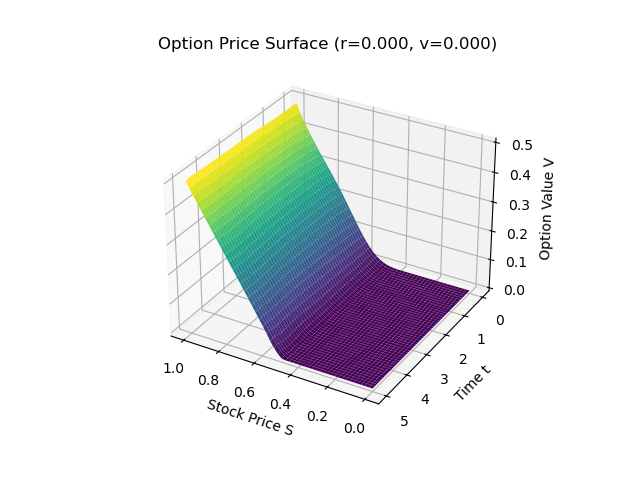

In [16]:
plot_surface(model, r_val=0., v_val=0.0)

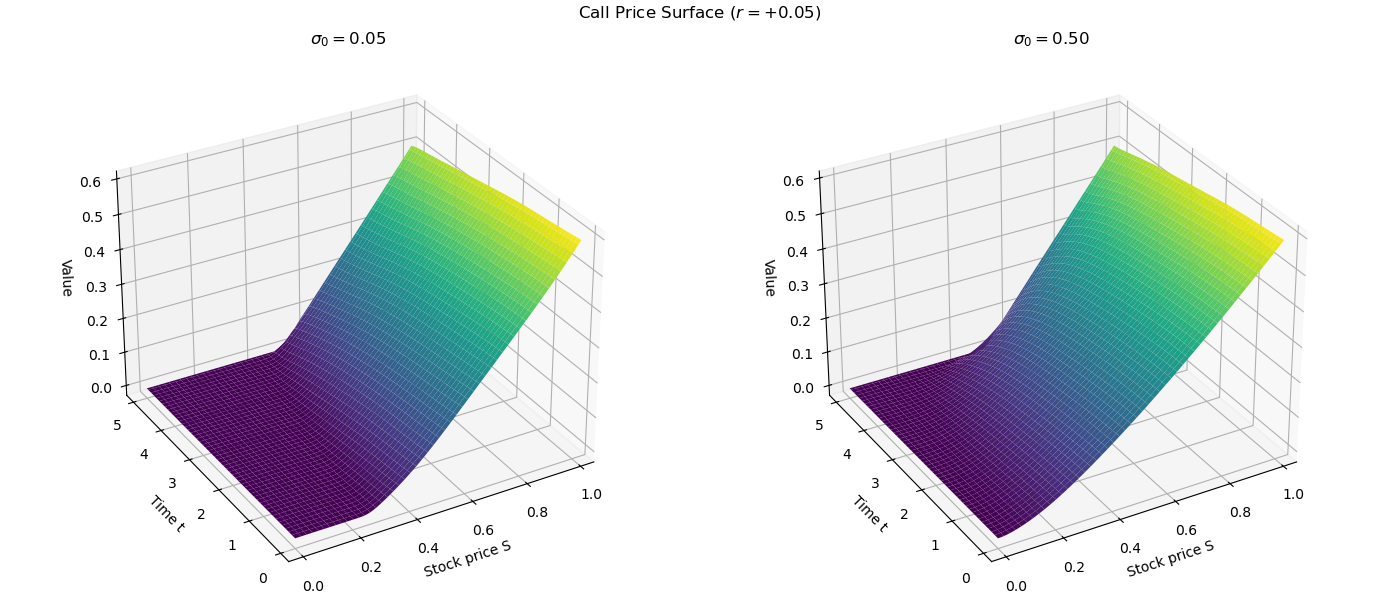

In [33]:
r_fixed      = 0.05            # rate held fixed in the 3-D slices
v_slices     = [0.05, 0.5] # three v values for the row of surfaces
spot_S       = STRIKE          # evaluate “at-the-money” (S = K)

# grids for the surfaces
n_t, n_s = 100, 100
t_grid   = torch.linspace(0.0, T, n_t, device=DEV, dtype=DTYPE)
s_grid   = torch.linspace(s_min, s_max, n_s, device=DEV, dtype=DTYPE)
T_mesh, S_mesh = torch.meshgrid(t_grid, s_grid, indexing='ij')


# ================================================================
# Helper for a single price
# ================================================================
def price_point(t, s, r, v):
    t_t = torch.tensor([t], device=DEV, dtype=DTYPE)
    s_t = torch.tensor([s], device=DEV, dtype=DTYPE)
    r_t = torch.tensor([r], device=DEV, dtype=DTYPE)
    v_t = torch.tensor([v], device=DEV, dtype=DTYPE)
    return model_price(model, t_t, s_t, r_t, v_t).item()


from matplotlib import cm, colors
def pad(lo, hi, pct=0.05):
    span = hi - lo
    return lo - pct*span, hi + pct*span

# first pass – evaluate model on each (t,S) grid so we know global colour limits
V_meshes, vmin, vmax = [],  +np.inf, -np.inf
for v_fixed in v_slices:
    r_mesh = torch.full_like(T_mesh.flatten(), r_fixed, device=DEV, dtype=DTYPE)
    v_mesh = torch.full_like(T_mesh.flatten(), v_fixed, device=DEV, dtype=DTYPE)
    with torch.no_grad():
        V = model_price(model,
                        T_mesh.flatten(), S_mesh.flatten(),
                        r_mesh, v_mesh).reshape(T_mesh.shape)
    V_meshes.append(V)
    vmin = min(vmin, V.min().item())
    vmax = max(vmax, V.max().item())

# figure + three sub-axes (constrained so labels aren’t cut)
fig, axes = plt.subplots(1, 2, figsize=(14, 6),      # ← wider canvas
                         subplot_kw={'projection': '3d'},
                         constrained_layout=True)

for ax, v_fixed, V in zip(axes, v_slices, V_meshes):
    ax.view_init(elev=30, azim=-120)
    surf = ax.plot_surface(S_mesh.cpu().numpy(),
                           T_mesh.cpu().numpy(),
                           V.cpu().numpy(),
                           cmap='viridis', vmin=vmin, vmax=vmax,
                           linewidth=0, antialiased=True)
    ax.set_xlabel('Stock price S'); ax.set_ylabel('Time t'); ax.set_zlabel('Value')
    ax.set_title(rf'$\sigma_0={v_fixed:.2f}$')
    ax.set_xlim(*pad(S_mesh.min().item(), S_mesh.max().item()))
    ax.set_ylim(*pad(T_mesh.min().item(), T_mesh.max().item()))
    ax.set_zlim(*pad(V.min().item(), V.max().item()))

# centred figure-wide title --------------------------------------------------
fig.suptitle(f'Call Price Surface ($r = {r_fixed:+.02f}$)')

plt.show()

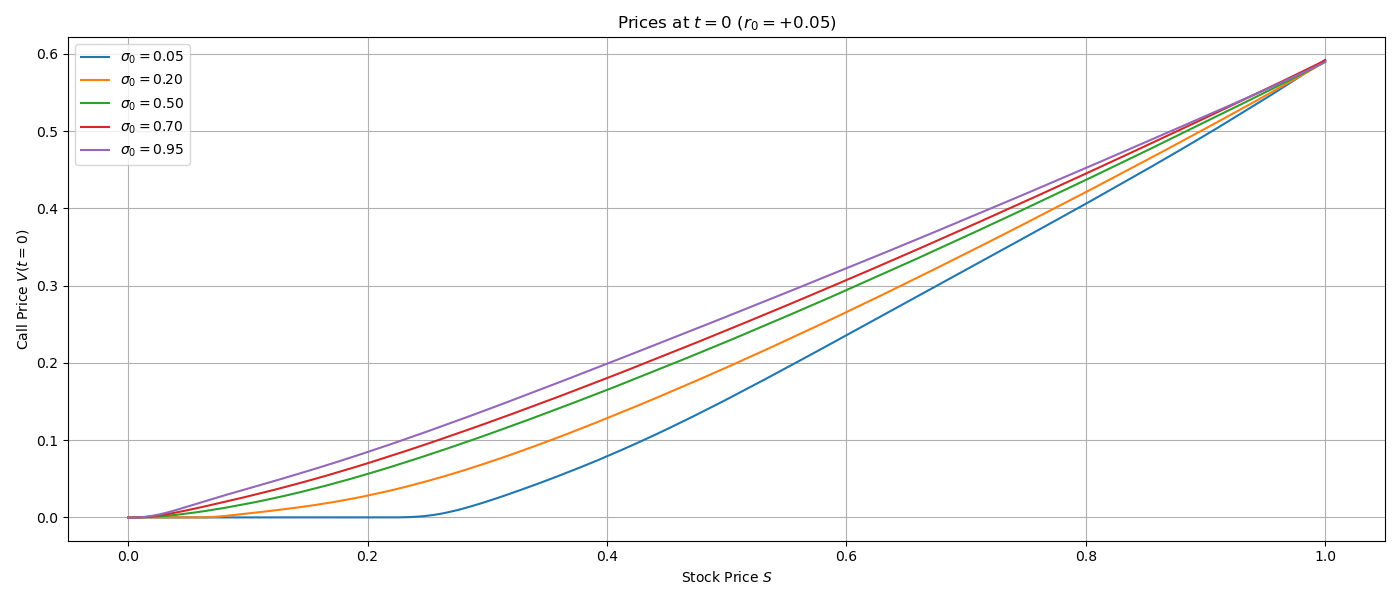

In [34]:
# ================================================================
# (2) – Price curves at t = 0  (x-axis = stock S) ----------------
# ================================================================
s_curve = torch.linspace(s_min, s_max, 200, device=DEV, dtype=DTYPE)
t0      = torch.zeros_like(s_curve)              # t = 0 for every point

# ------------------------------------------------
# (2a) curves for different v  (r fixed)
# ------------------------------------------------
r_fixed_line = 0.05       # same r that was used in the surface row
v_plot       = [0.05, 0.2, 0.5, 0.7, 0.95]

fig, ax = plt.subplots(figsize=(14, 6))
for v in v_plot:
    r_t = torch.full_like(s_curve, r_fixed_line, device=DEV, dtype=DTYPE)
    v_t = torch.full_like(s_curve, v,               device=DEV, dtype=DTYPE)
    prices = model_price(model, t0, s_curve, r_t, v_t).cpu().numpy()
    ax.plot(s_curve.cpu().numpy(), prices, label=f'$\sigma_0={v:.2f}$')

ax.set_xlabel('Stock Price $S$')
ax.set_ylabel('Call Price $V(t=0)$')
ax.set_title(f'Prices at $t=0$ ($r_0={r_fixed_line:+.2f}$)')
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()

/var/folders/cp/l432p0ns1t38qmnyr_3l3r000000gn/T/ipykernel_84430/2575428358.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(14, 6))


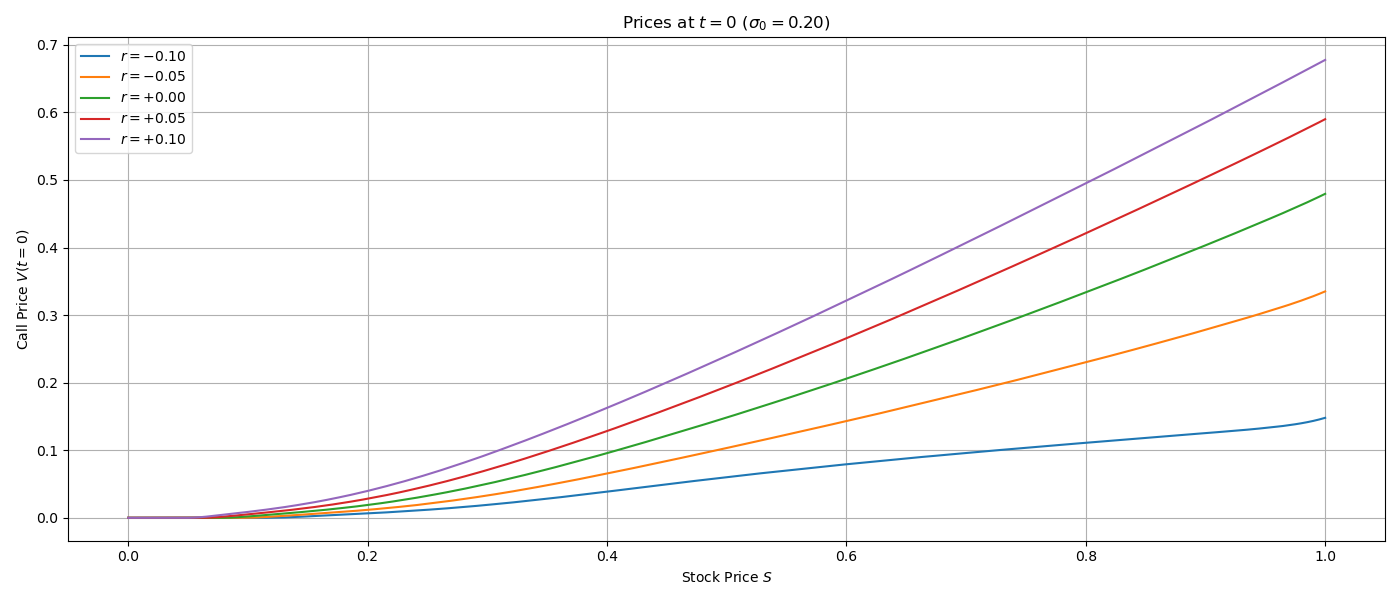

In [35]:
# ------------------------------------------------
# (2b) curves for different r  (v fixed)
# ------------------------------------------------
v_fixed_line = 0.20       # same v that was used in the surface row
r_plot       = [-0.10, -0.05, 0.0, 0.05, 0.10]

fig, ax = plt.subplots(figsize=(14, 6))
for r in r_plot:
    r_t = torch.full_like(s_curve, r,               device=DEV, dtype=DTYPE)
    v_t = torch.full_like(s_curve, v_fixed_line,    device=DEV, dtype=DTYPE)
    prices = model_price(model, t0, s_curve, r_t, v_t).cpu().numpy()
    ax.plot(s_curve.cpu().numpy(), prices, label=f'$r={r:+.2f}$')

ax.set_xlabel('Stock Price $S$')
ax.set_ylabel('Call Price $V(t=0)$')
ax.set_title(f'Prices at $t=0$ ($\sigma_0={v_fixed_line:.2f}$)')
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()